In [16]:
import pandas as pd

data_full = pd.read_excel("data/Capstone_Final_Dataset.xlsx")

In [17]:
#First I will keep only Geo info, Category info, Grant info, and Mission/Pillar info
data_full = data_full.drop(columns=[
    'Category', 
    'Geographic Scope',
    'DEI Priorities', 'Tier',
    'Verified Grant URL / Contact', 'Confirmed Application Deadlines',
    'Strategic Note / Pitch Angle', 'Partnership Potential',
    'Best Pitch Angle', 'Enhanced Notes', 'Contact Person', 'Typical Grant Size',
    'Application Process'
])


In [18]:
mask = (
    (data_full['Financial Funder'] == 1) &
    data_full['Typical Min. Grant Size'].notna() &
    data_full['Typical Max. Grant Size'].notna()
)
data_full = data_full.loc[mask].copy()


# As a first pass of the data analysis i will only keep the orgs that are financial funders! I.e. labeled 1 in the Financial Funder column

In [19]:
data_full.columns

Index(['Organization', 'Crowdfunding', 'Collegiate', 'Pro Sports League',
       'Pro Sports (NFL)', 'Pro Sports (MLB)', 'Pro Sports (USL)',
       'Pro Sports (NBA)', 'Pro Sports (MLS)', 'Pro Sports (NHL)',
       'Thought Leader', 'National Non-Profit', 'Federal Grant',
       'Venture Capital', 'Athlete Foundation', 'Corporate Foundation',
       'Education Foundation', 'Geo_Focus', 'Mission / Stated Pillars',
       'Financial Funder', 'Typical Min. Grant Size',
       'Typical Max. Grant Size', 'Label'],
      dtype='object')

In [20]:
import re

# Combine all text in the column into one string
text = " ".join(data_full["Mission / Stated Pillars"].astype(str))

# Split by spaces and punctuation
tokens = re.findall(r"\b\w+\b|[^\w\s]", text)

# Get unique tokens
unique_tokens = sorted(set(tokens))

# Display
print(unique_tokens)
print(f"\nTotal unique tokens: {len(unique_tokens)}")

['$', '&', "'", '(', ')', ',', '-', '.', '/', '000', '100', '12', '14', '2025', '24', '50', ':', ';', 'A', 'AI', 'Advances', 'All', 'Almost', 'Animal', 'Application', 'Area', 'Arizona', 'Arts', 'Autism', 'Baltimore', 'Bay', 'Being', 'Berkeley', 'Black', 'Brilliant', 'Care', 'Carolina', 'Central', 'Change', 'Children', 'Civic', 'ClassDojo', 'Communities', 'Community', 'Concept', 'Conservation', 'Degreed', 'Development', 'Distributes', 'DonorsChoose', 'Eagles', 'Eat', 'Economic', 'Educate', 'Education', 'Employment', 'Enhanced', 'Ensure', 'Environmental', 'Equal', 'Families', 'Florida', 'Focuses', 'Fosters', 'Foundation', 'Fund', 'Funds', 'GAP', 'Garden', 'Getting', 'Girls', 'Global', 'Good', 'Grant', 'Grants', 'Harnesses', 'Has', 'Health', 'Helping', 'Hero', 'Hockey', 'Homelessness', 'Honors', 'Houston', 'IES', 'Inclusive', 'Indiana', 'Innovative', 'Inspire', 'Institute', 'Invests', 'Issues', 'Justice', 'K', 'Kickstarter', 'Kiddom', 'Kyron', 'League', 'Learn', 'Learning', 'MLB', 'Madiso

In [21]:
# --- 0) Light text clean (keep punctuation/stopwords) ---
def clean_mission(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = s.replace("\n", " ").replace("\r", " ")
    s = re.sub(r"\s*[\u2022•·\-–—]\s*", "; ", s)  # bullets -> semicolons
    s = re.sub(r"\s+", " ", s).strip()
    return s

data_full['mission_clean'] = data_full['Mission / Stated Pillars'].apply(clean_mission)


In [22]:
import re
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

def print_cluster_terms_safe(
    texts,
    labels,
    topn=12,
    method="relative",      # "relative" or "mean"
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    extra_stops=None,
    include_noise=False,
    min_cluster_size_to_print=1,
    verbose=True
):
    labels = np.asarray(labels)
    uniq, cnts = np.unique(labels, return_counts=True)
    if verbose:
        print("Label distribution:", dict(zip(uniq.tolist(), cnts.tolist())))

    if extra_stops is None:
        extra_stops = {
            "foundation","nonprofit","program","programs",
            "students","youth","community","support",
            "organization","organizations"
        }
    stopwords = list(ENGLISH_STOP_WORDS.union(extra_stops))

    docs = ["" if t is None else str(t) for t in texts]

    def try_vectorizer(_min_df, _max_df, _ngram_range, _stopwords):
        tfidf = TfidfVectorizer(
            stop_words=_stopwords,
            ngram_range=_ngram_range,
            min_df=_min_df,
            max_df=_max_df,
            sublinear_tf=True
        )
        X = tfidf.fit_transform(docs)
        terms = np.array(tfidf.get_feature_names_out())
        return X, terms

    Xtf = terms = None
    # Progressive relaxation if vocab is empty
    relax_plan = [
        (min_df,   max_df,   ngram_range, stopwords),
        (1,        max_df,   ngram_range, stopwords),
        (1,        1.0,      (1,1),       stopwords),
        (1,        1.0,      (1,1),       None),        # no stopwords at all
    ]

    for (md, mx, ngr, sw) in relax_plan:
        try:
            Xtf, terms = try_vectorizer(md, mx, ngr, sw)
            if verbose:
                print(f"Vectorizer OK with min_df={md}, max_df={mx}, ngram_range={ngr}, "
                      f"stopwords={'custom' if sw is not None else 'None'}; vocab={len(terms)}")
            break
        except ValueError as e:
            if "empty vocabulary" in str(e).lower():
                if verbose:
                    print(f"Retrying vectorizer due to empty vocabulary... tried "
                          f"min_df={md}, max_df={mx}, ngram_range={ngr}, "
                          f"stopwords={'custom' if sw is not None else 'None'}")
                continue
            else:
                raise

    if Xtf is None or Xtf.shape[1] == 0:
        # Final ultra-safe fallback: simple token counts without sklearn
        if verbose:
            print("Falling back to simple token counts (regex).")
        token_pat = re.compile(r"[A-Za-z]{3,}")
        tokenized = [token_pat.findall(d.lower()) for d in docs]
        labels_list = labels.tolist()
        for cid in sorted(set(labels_list)):
            if cid == -1 and not include_noise:
                continue
            idx = [i for i, l in enumerate(labels_list) if l == cid]
            if len(idx) < min_cluster_size_to_print:
                continue
            bag = Counter()
            for i in idx:
                bag.update(tokenized[i])
            common = [w for w, _ in bag.most_common(topn)]
            print(f"\nCluster {cid} (n={len(idx)}): " + ", ".join(common))
        return

    # Use non-noise docs for corpus_mean; if all noise, use all
    valid_mask = (labels != -1) if (labels != -1).any() else np.ones_like(labels, dtype=bool)
    corpus_mean = np.asarray(Xtf[valid_mask].mean(axis=0)).ravel() + 1e-9

    printed_any = False
    for cid in sorted(set(labels)):
        if cid == -1 and not include_noise:
            continue
        idx = np.where(labels == cid)[0]
        if len(idx) < min_cluster_size_to_print:
            continue
        Xc = Xtf[idx]
        mean_tfidf = np.asarray(Xc.mean(axis=0)).ravel()
        score = (mean_tfidf / corpus_mean) if method == "relative" else mean_tfidf
        if score.size == 0:
            continue
        top = score.argsort()[::-1][:topn]
        print(f"\nCluster {cid} (n={len(idx)}): " + ", ".join(terms[top]))
        printed_any = True

    if not printed_any and verbose:
        print("No clusters printed (likely all noise or clusters < min_cluster_size_to_print). "
              "Consider lowering HDBSCAN min_cluster_size/min_samples or set include_noise=True.")


In [23]:
from sentence_transformers import SentenceTransformer
import hdbscan
import numpy as np

# 1) Embeddings (normalize for cosine-like geometry)
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(data_full['mission_clean'].tolist(), normalize_embeddings=True)

# 2) HDBSCAN directly on embeddings (no UMAP)
clusterer = hdbscan.HDBSCAN(
    metric='euclidean',            # with L2-normalized vectors, Euclidean ≈ cosine
    min_cluster_size=4,
    cluster_selection_method='eom'
)
labels = clusterer.fit_predict(embeddings)
data_full["cluster_mission"] = labels

print(np.unique(labels, return_counts=True))


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e334e0df-89bf-4c81-a323-83524abe8401)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


(array([-1]), array([70]))


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
print_cluster_terms_safe(
    texts=data_full["mission_clean"],
    labels=labels,
    topn=12,
    method="relative",          # or "mean"
    include_noise=False,        # set True if you want cluster -1 terms too
    min_cluster_size_to_print=2 # skip singletons
)


Label distribution: {-1: 70}
Vectorizer OK with min_df=2, max_df=0.9, ngram_range=(1, 2), stopwords=custom; vocab=138
No clusters printed (likely all noise or clusters < min_cluster_size_to_print). Consider lowering HDBSCAN min_cluster_size/min_samples or set include_noise=True.


In [25]:
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# 1️⃣ Embeddings (use mpnet for best semantics)
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(data_full['mission_clean'].tolist(), normalize_embeddings=True)

# 2️⃣ UMAP dimensionality reduction (preserves meaning structure)
um = umap.UMAP(
    n_neighbors=10,
    n_components=15,          # can try 10–20
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
X_umap = um.fit_transform(embeddings)

# 3️⃣ HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    metric='euclidean',       # since UMAP outputs Euclidean
    min_cluster_size=5,
    cluster_selection_method='eom'
)
labels = clusterer.fit_predict(X_umap)
data_full["cluster_mission"] = labels

print(np.unique(labels, return_counts=True))


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a06766c7-1543-49f3-9d99-c0ada8476990)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/config.json
Retrying in 1s [Retry 1/5].


(array([-1,  0,  1,  2]), array([13, 13, 29, 15]))


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
print_cluster_terms_safe(
    texts=data_full["mission_clean"],
    labels=labels,
    topn=12,
    method="relative",          # or "mean"
    include_noise=False,        # set True if you want cluster -1 terms too
    min_cluster_size_to_print=2 # skip singletons
)

Label distribution: {-1: 13, 0: 13, 1: 29, 2: 15}
Vectorizer OK with min_df=2, max_df=0.9, ngram_range=(1, 2), stopwords=custom; vocab=138

Cluster 0 (n=13): profit, non profit, serve children, arizona, family, game, profits help, areas, focus areas, key pillar, education key, non

Cluster 1 (n=29): development education, fitness, veterans, supporting education, education development, health education, recreation, inspire, physical, leadership development, school, hockey

Cluster 2 (n=15): funding, world, mission, based, founders, entrepreneurial, companies, funds, ai, invests, human, includes


In [27]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
import umap.umap_ as umap

umap_2d = umap.UMAP(
    n_neighbors=10,
    n_components=2,      # 2D for visualization
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
X_2d = umap_2d.fit_transform(embeddings)   # or X_umap if you prefer 15→2


/opt/anaconda3/envs/Iterlight/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


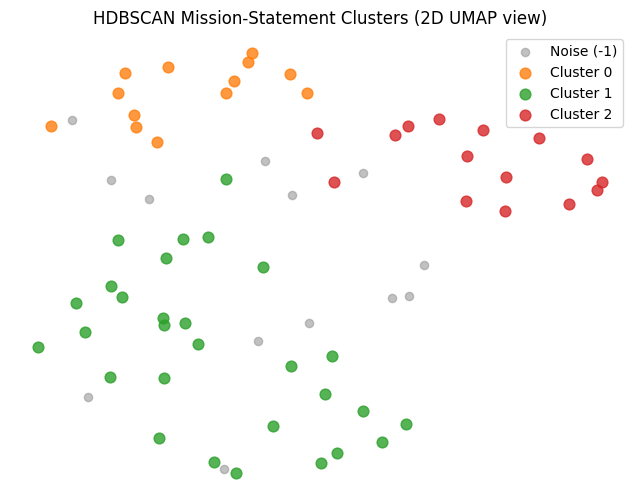

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare colors
unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))

plt.figure(figsize=(8,6))
for lab, col in zip(unique_labels, palette):
    mask = labels == lab
    if lab == -1:
        plt.scatter(X_2d[mask,0], X_2d[mask,1],
                    c=[(0.6,0.6,0.6)], s=35, alpha=0.6, label="Noise (-1)")
    else:
        plt.scatter(X_2d[mask,0], X_2d[mask,1],
                    c=[col], s=60, alpha=0.8, label=f"Cluster {lab}")

plt.title("HDBSCAN Mission-Statement Clusters (2D UMAP view)")
plt.legend()
plt.axis("off")
plt.show()


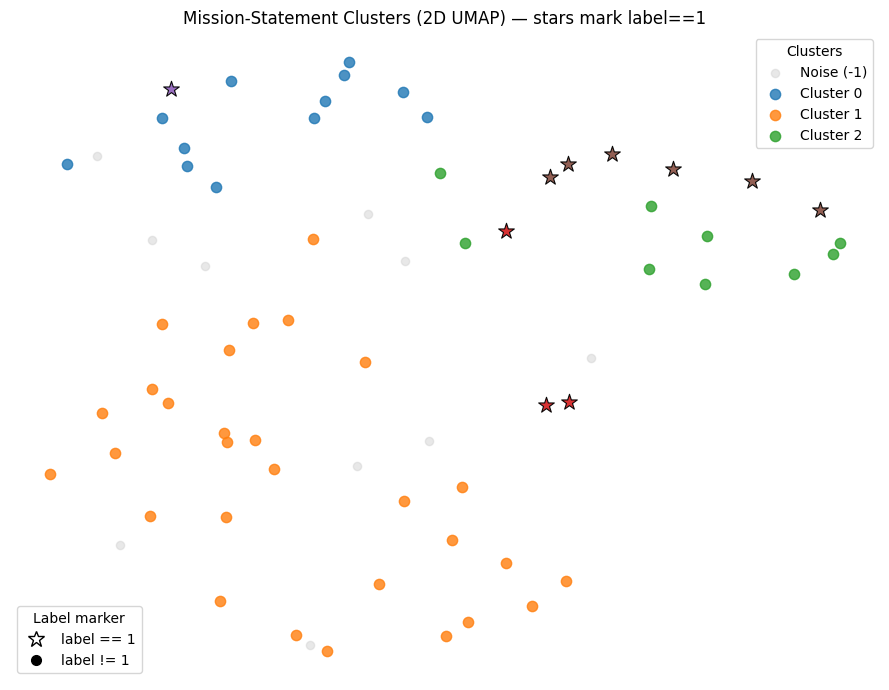

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# assumes you already have: X_2d (shape [n,2]), labels (HDBSCAN ints), data_full["label"]
star_mask = (data_full["Label"].fillna(0).astype(int) == 1).to_numpy()
unique_clusters = np.unique(labels)

plt.figure(figsize=(9,7))

# 1) plot dots (label != 1) per cluster
for cid in unique_clusters:
    mask = (labels == cid) & (~star_mask)
    if cid == -1:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=35, alpha=0.5, c='lightgray', label="Noise (-1)")
    else:
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=55, alpha=0.8, label=f"Cluster {cid}")

# 2) overlay stars (label == 1) per cluster (plot second so they sit on top)
for cid in unique_clusters:
    mask = (labels == cid) & (star_mask)
    if not np.any(mask):
        continue
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                s=140, marker='*', linewidths=0.8, edgecolors='k', alpha=0.95,
                label=None)  # we’ll add a custom legend entry below

# 3) add a legend entry for the star marker (proxy artist)
from matplotlib.lines import Line2D
star_legend = Line2D([0], [0], marker='*', color='w', label='label == 1',
                     markeredgecolor='k', markerfacecolor='none', markersize=12, linewidth=0)
dot_legend  = Line2D([0], [0], marker='o', color='w', label='label != 1',
                     markeredgecolor='k', markerfacecolor='k', markersize=7, linewidth=0)

# combine cluster legend + marker legend
first_legend = plt.legend(loc='best', title="Clusters", frameon=True)
plt.gca().add_artist(first_legend)
plt.legend(handles=[star_legend, dot_legend], loc='lower left', title="Label marker", frameon=True)

plt.title("Mission-Statement Clusters (2D UMAP) — stars mark label==1")
plt.axis('off')
plt.tight_layout()
plt.show()


In [31]:
data_full.loc[data_full['Organization'].str.contains('IterLight', case=False, na=False),
              ['Organization','cluster_mission']]

,Organization,cluster_mission
0,IterLight,-1
